###### 라이브러리

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=33866b9404aa1b6196b922cca72f3173c9b44b6990daa0dcf7290ef212550182
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, silhouette_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from bayes_opt import BayesianOptimization

###### Kmode

In [ ]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

###### csv 파일 불러오기

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(['index', 'country', 'introelapse', 'testelapse', 'surveyelapse'], axis=1)
test = test.drop(['index', 'country', 'introelapse', 'testelapse', 'surveyelapse'], axis=1)
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0


###### 의존도가 낮은 ASD 제거

In [ ]:
train = train.drop(['ASD'], axis=1)
test = test.drop(['ASD'], axis=1)

In [ ]:
Q_columns = ['Q' + str(num) for num in range(1, 27)]
TIPI_columns = ['TIPI' + str(num) for num in range(1, 11)]
VCL_columns = ['VCL' + str(num) for num in range(1, 17)]
info_columns = ['education', 'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation', 'voted', 'married', 'familysize', 'ASD']

###### 결측치를 최빈값으로 대체

In [ ]:
print(train.isnull().sum().sum())

for column in train.columns:
  if column == 'nerdiness':
    continue
  mode = train[column].mode()[0]
  train[column] = train[column].fillna(mode)
  test[column] = test[column].fillna(mode)

print(train.isnull().sum().sum())

3105
0


###### age, familysize 처리
age : 100 이상은 100으로 통일, 10 단위로 분할  
familysize : 10 이상은 10으로 통일

In [ ]:
def handle_age_family(df):
  df['age'] = df['age'].map(lambda x: min(100, x))
  for age in range(0, 100, 10):
    df.loc[(age <= df['age']) & (df['age'] < age + 10), 'age'] = age // 10
    
  df['familysize'] = df['familysize'].map(lambda x: min(10, x))
  return df

train = handle_age_family(train)
test = handle_age_family(test)

###### 신뢰도(reliability) 추가

In [ ]:
def add_reliability(df):
  df['reliability'] = (3 - df[['VCL6', 'VCL9', 'VCL12']].sum(axis=1)) / 3
  return df

train = add_reliability(train)
test = add_reliability(test)

train = train.drop(VCL_columns, axis=1)
test = test.drop(VCL_columns, axis=1)

train['reliability']

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4        1.000000
           ...   
14995    0.666667
14996    1.000000
14997    1.000000
14998    0.666667
14999    0.333333
Name: reliability, Length: 15000, dtype: float64

###### TEN-ITEM PERSONALITY INVENTORY-(TIPI)

In [ ]:
def handle_TIPI(df):
  df['extraversion'] = df['TIPI1'] + 6 - df['TIPI6']
  df['agreeableness'] = 6 - df['TIPI2'] + df['TIPI7']
  df['conscientiousness'] = df['TIPI3'] + 6 - df['TIPI8']
  df['emotional_stability'] = 6 - df['TIPI4'] + df['TIPI9']
  df['openness_to_experiences'] = df['TIPI5'] + 6 - df['TIPI10']
  df = df.drop(TIPI_columns, axis=1)
  return df

train = handle_TIPI(train)
test = handle_TIPI(test)

TIPI_columns = ['extraversion', 'agreeableness', 'conscientiousness', 'emotional_stability', 'openness_to_experiences']

###### Target Encoding

In [ ]:
for column in test.columns:
  mean = train.groupby(column)['nerdiness'].mean()
  train[column] = train[column].map(mean)
  test[column] = test[column].map(mean)

train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,voted,married,familysize,nerdiness,reliability,extraversion,agreeableness,conscientiousness,emotional_stability,openness_to_experiences
0,0.219430,0.682683,0.644737,0.687265,0.270300,0.579689,0.648825,0.664512,0.287443,0.462615,...,0.548279,0.559330,0.547405,1,0.534069,0.553535,0.573861,0.578765,0.559509,0.480897
1,0.549147,0.490676,0.505430,0.576165,0.538382,0.754382,0.494185,0.537294,0.460687,0.462615,...,0.562683,0.515796,0.547405,1,0.534069,0.508982,0.538540,0.578765,0.560396,0.535480
2,0.549147,0.682683,0.644737,0.576165,0.490014,0.754382,0.648825,0.664512,0.541905,0.523798,...,0.548279,0.529865,0.547405,1,0.534069,0.655729,0.563794,0.568217,0.559509,0.603476
3,0.549147,0.490676,0.505430,0.382335,0.538382,0.427424,0.435168,0.664512,0.460687,0.523798,...,0.548279,0.559330,0.565604,1,0.534069,0.491851,0.563794,0.568217,0.593059,0.553851
4,0.549147,0.490676,0.505430,0.576165,0.490014,0.427424,0.494185,0.413060,0.460687,0.523798,...,0.548279,0.559330,0.573536,0,0.534069,0.553535,0.513912,0.519537,0.593059,0.553851


###### PCA

In [ ]:
pca = PCA(n_components=4)
pca.fit(train[info_columns])

pca_columns = ['info_A', 'info_B', 'info_C', 'info_D']
train_pca = pd.DataFrame(data=pca.transform(train[info_columns]), columns=pca_columns)
test_pca = pd.DataFrame(data=pca.transform(test[info_columns]), columns=pca_columns)

train = pd.concat([train.drop(info_columns, axis=1), train_pca], axis=1)
test = pd.concat([test.drop(info_columns, axis=1), test_pca], axis=1)
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,TIPI7,TIPI8,TIPI9,TIPI10,nerdiness,reliability,info_A,info_B,info_C,info_D
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,5.0,3.0,5.0,3.0,1,1.0,7.975516,-0.210175,0.511540,2.716301
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,5.0,1.0,2.0,2.0,1,1.0,-1.963833,2.457590,-1.732523,0.085698
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,3.0,4.0,5.0,2.0,1,1.0,-1.983945,2.192521,-1.086823,1.093177
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,4.0,4.0,3.0,3.0,1,1.0,-3.096815,-1.057100,-0.152466,-0.759527
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,3.0,4.0,3.0,2.0,0,1.0,7.864666,-1.294985,1.067295,-1.435579


###### PCA 시각화

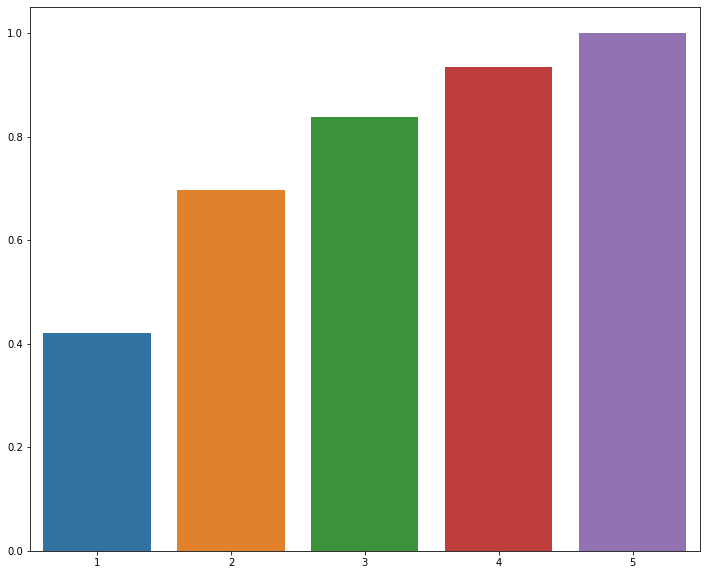

In [ ]:
def check_pca(columns):
  length = len(columns)

  x = [n for n in range(1, length + 1)]
  y = []

  for n in range(1, length + 1):  
    pca = PCA(n_components=n)
    pca.fit(train[columns])

    # train = pd.concat([train.drop(info_columns, axis=1), pd.DataFrame(data=pca.transform(train[info_columns]), columns=['A', 'B'])], axis=1)
    # test = pd.concat([test.drop(info_columns, axis=1), pd.DataFrame(data=pca.transform(test[info_columns]), columns=['A', 'B'])], axis=1)
    # train.head()
    y.append(pca.explained_variance_ratio_.sum())

  fig = plt.figure(figsize=(12, 10))
  sns.barplot(x=x, y=y)

check_pca(TIPI_columns)

###### Clustering

In [ ]:
def handle_clustering(train, test, columns, n_cluster, drop=False):
  train_kmeans = train[columns]
  test_kmeans = test[columns]

  kmeans = KMeans(n_clusters=n_cluster).fit(train_kmeans)
  train['cluster'] = kmeans.predict(train_kmeans)
  test['cluster'] = kmeans.predict(test_kmeans)

  if drop:
    train = train.drop(columns, axis=1)
    test = test.drop(columns, axis=1)
  return train, test

train, test = handle_clustering(train, test, info_columns, 5)

###### Clustering 결과 시각화

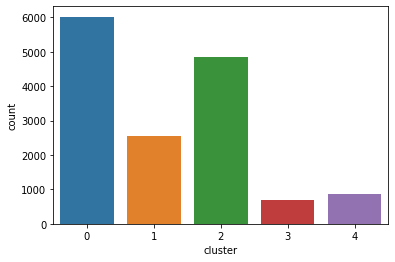

In [ ]:
sns.countplot(x='cluster', data=train)

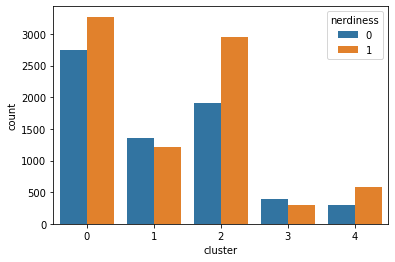

In [ ]:
sns.countplot(x='cluster', hue='nerdiness', data=train)

<BarContainer object of 5 artists>

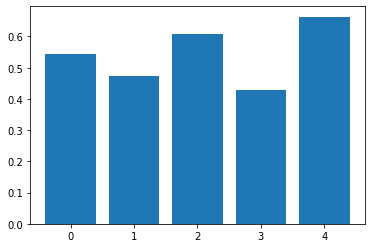

In [ ]:
temp = train.groupby('cluster')['nerdiness'].mean()
plt.bar(x=range(5), height=temp)

###### Elbow Method, Silhouette Analysis

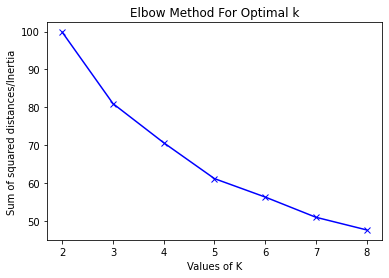

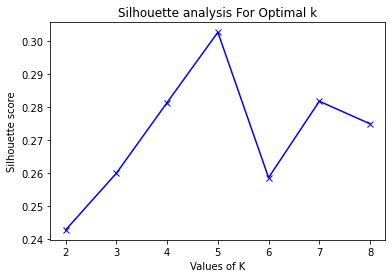

In [ ]:
def elbow_silhouette(max_n_clusters, columns):
  Sum_of_squared_distances = []
  silhouette_avg = []
  K = range(2, max_n_clusters + 1)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans_train = train[columns]
    kmeans.fit(kmeans_train)
    Sum_of_squared_distances.append(kmeans.inertia_)

    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(kmeans_train, cluster_labels))

  plt.plot(range(2, max_n_clusters + 1),Sum_of_squared_distances,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

  plt.plot(range(2, max_n_clusters + 1),silhouette_avg,'bx-')
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette score') 
  plt.title('Silhouette analysis For Optimal k')
  plt.show()

elbow_silhouette(8, info_columns)

###### 현재 column 확인

In [ ]:
print(*list(train.columns))
print(*list(test.columns))

Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8 Q9 Q10 Q11 Q12 Q13 Q14 Q15 Q16 Q17 Q18 Q19 Q20 Q21 Q22 Q23 Q24 Q25 Q26 education urban gender engnat age hand religion orientation voted married familysize nerdiness reliability extraversion agreeableness conscientiousness emotional_stability openness_to_experiences
Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8 Q9 Q10 Q11 Q12 Q13 Q14 Q15 Q16 Q17 Q18 Q19 Q20 Q21 Q22 Q23 Q24 Q25 Q26 education urban gender engnat age hand religion orientation voted married familysize reliability extraversion agreeableness conscientiousness emotional_stability openness_to_experiences


###### 모델 정의

In [ ]:
def create_model():
  return RandomForestClassifier(n_estimators=int(378.2),
                                min_samples_split=int(5.8),
                                max_depth=149.4)

###### Bayesian Optimization

In [ ]:
x = np.array(train.drop(['nerdiness'], axis=1))
y = train['nerdiness']

def black_box_function(n_estimators, max_depth, min_samples_split):
    kf = KFold(n_splits=7)
    score = []
    for i, (train_index, valid_index) in enumerate(kf.split(x)):
      train_x, valid_x = x[train_index], x[valid_index]
      train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

      model = RandomForestClassifier(n_estimators=int(n_estimators),
                                     max_depth=max_depth,
                                     min_samples_split=int(min_samples_split))
      model.fit(train_x, train_y)
      score.append(roc_auc_score(model.predict(valid_x), valid_y))
    return sum(score) / 7

parameters = {"n_estimators": (10, 1000),
              "max_depth": (1, 150),
              "min_samples_split": (2, 10)}

optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = parameters, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7935   |  145.1    |  6.378    |  973.0    |
|  2        |  0.7902   |  107.5    |  7.582    |  223.9    |
|  3        |  0.795    |  146.5    |  2.05     |  260.5    |
|  4        |  0.7886   |  65.78    |  8.235    |  205.7    |
|  5        |  0.7881   |  129.6    |  9.867    |  172.2    |
|  6        |  0.7942   |  149.2    |  6.349    |  260.2    |
|  7        |  0.7952   |  121.4    |  2.291    |  274.1    |
|  8        |  0.7951   |  148.2    |  2.141    |  309.5    |
|  9        |  0.7945   |  102.9    |  2.033    |  334.7    |
|  10       |  0.7956   |  149.4    |  5.8      |  378.2    |
|  11       |  0.7892   |  107.2    |  9.863    |  420.0    |
|  12       |  0.7941   |  145.3    |  2.745    |  347.6    |
|  13       |  0.795    |  38.99    |  4.565    |  320.4    |
|  14       |  0.7219   |  1.554    |  4.898    |  352.6    |
|  15   

In [ ]:
optimizer.

###### 모델 평가

In [ ]:
x = np.array(train.drop(['nerdiness'], axis=1))
y = train['nerdiness']

kf = KFold(n_splits=7)
accuracy = []
for i, (train_index, valid_index) in enumerate(kf.split(x)):
  train_x, valid_x = x[train_index], x[valid_index]
  train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]

  model = create_model()
  model.fit(train_x, train_y)
  accuracy.append(accuracy_score(model.predict(valid_x), valid_y))
  print(accuracy[-1])
print(f'Score : {sum(accuracy) / 7}')

0.7881474568362109
0.7993467102193187
0.7942137190853943
0.7764815678954736
0.8142790480634624
0.7872141857209519
0.7964519140989729
Score : 0.7937335145599692


###### 의존도 시각화

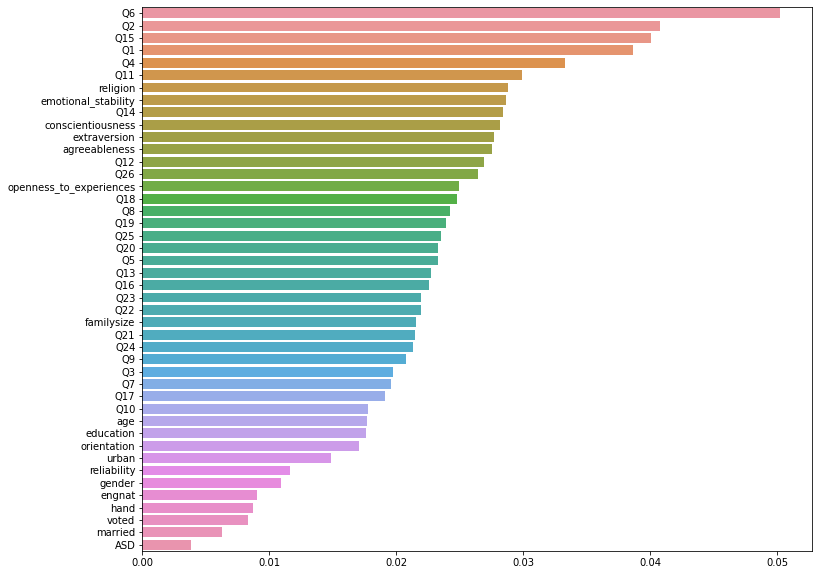

In [ ]:
model  = create_model()
model.fit(x, y)
importances_values = model.feature_importances_
importances = pd.Series(importances_values, index=test.columns)
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x = importances, y = importances.index)
plt.show()

In [ ]:
model = create_model()
model.fit(x, y)
prediction = model.predict(test)
prediction.values

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['nerdiness'] = prediction
submission.to_csv('submission_18.csv', index = False)
submission

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
35447,35447,1
35448,35448,1
35449,35449,1
35450,35450,0


###### submission.csv 생성

In [ ]:

prediction = []
for model in models:
  prediction.append(model.predict_proba(test)[:,1])

prediction = pd.DataFrame(prediction)
prediction = prediction.sum()
prediction = prediction / 17
prediction = prediction.map(lambda x: 0 if x < 0.5 else 1)
prediction.values

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['nerdiness'] = prediction.values
submission.to_csv('submission_18.csv', index = False)
submission

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
35447,35447,1
35448,35448,1
35449,35449,1
35450,35450,0
